## ADA Project : Milestone 2

### Analyzing User Behaviour

Quick placeholder

The Wikispeedia game leverages the complex web of wikipeedia articles to offer players a chance to test their knowledge and connection finding skills. In this project, we embark on an analytical journey to unravel one aspect of this network : the cognitive behaviour of players and it's outcome on in-game success. //TODO : give outline of what is done in the project .

### Imports

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
import seaborn as sns
import warnings
import urllib.parse
warnings.filterwarnings('ignore')

###  Part 1 -  Data Overview and Pre-processing :

### 1) Data exploration :

Let's first explore the data and see statistics for each dataframe

In [3]:
# Read the finished paths dataset
finished_paths = pd.read_csv("wikispeedia_paths-and-graph/paths_finished.tsv", sep='\t', skiprows = 17, names=['hashedIpAddress','timestamp','durationInSec','path','rating'])

# Read the unfinished paths dataset
unfinished_paths = pd.read_csv("wikispeedia_paths-and-graph/paths_unfinished.tsv", sep='\t', skiprows = 17, names=['hashedIpAddress' ,  'timestamp' ,  'durationInSec' ,  'path' ,  'target'   ,'type'])

# Read the categories dataset
categories = pd.read_csv("wikispeedia_paths-and-graph/categories.tsv", sep='\t', skiprows = 12, names=['article', 'category'])

# links.tsv contains all links between articles. 
links = pd.read_csv("wikispeedia_paths-and-graph/links.tsv", sep='\t', skiprows = 11, names = ['link_source', 'link_target'])

Let's see the structure of each one of our datasets : 

In [4]:
print('finished_paths dataframe structure :')
finished_paths.head(5)

finished_paths dataframe structure :


,hashedIpAddress,timestamp,durationInSec,path,rating
0,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
1,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
2,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
3,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0
4,5295bca242be81fe,1372890414,110,14th_century;Europe;North_America;United_State...,NaN


In [5]:
print('unfinished_paths dataframe structure :')
unfinished_paths.head(5)

unfinished_paths dataframe structure :


,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


In [6]:
print('categories dataframe structure :')
categories.head(5)

categories dataframe structure :


,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists


In [7]:
print('links dataframe structure :')
links.head(5)

links dataframe structure :


,link_source,link_target
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland


We note that some article names appear with unusual characters, after a bit of inspection it is simply due to a character encoding mismatch (the wikipedia article names are given in utf-8 encoding) we can have see that :  

In [8]:
# Reading the first source string with the correct character encoding 
urllib.parse.unquote(links["link_source"].iloc[0])

'Áedán_mac_Gabráin'

We keep this in mind in case we need to uncover some article names, but since the dataset seems to be coherent in the encoding use this will not constitute a problem for our analyis.

We now ask ourselves the question, how are the links distributed among pages ? 

In order to answer our question we proceed by creating a histogram to see the distribution of outgoing and incoming links of articles : 

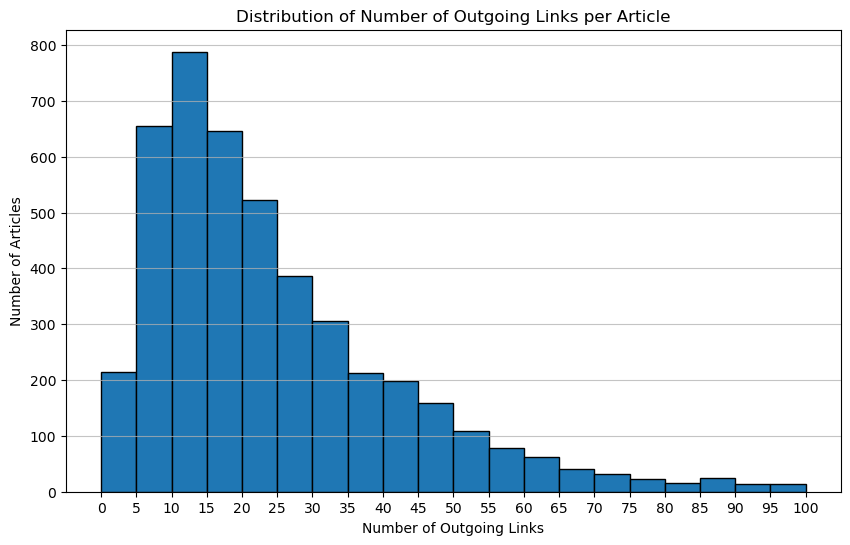

In [9]:
outgoing_link_counts = links.groupby('link_source').size()

# Creating the outgoing edges histogram

bins= range(0, 101, 5)
plt.figure(figsize=(10, 6))
plt.hist(outgoing_link_counts, bins= bins, edgecolor='black')
plt.title('Distribution of Number of Outgoing Links per Article')
plt.xlabel('Number of Outgoing Links')
plt.ylabel('Number of Articles')
plt.xticks(bins)
plt.grid(axis='y', alpha=0.75)
plt.show()

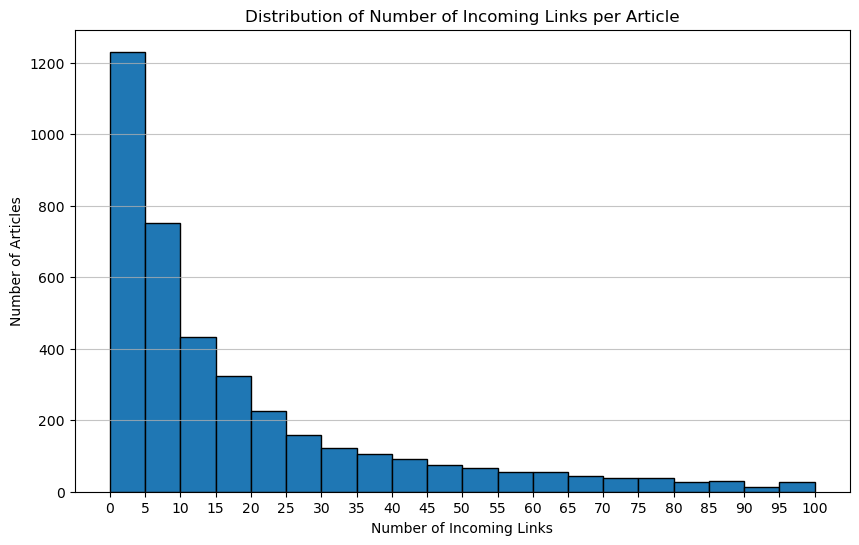

In [10]:
incoming_link_count = links.groupby('link_target').size()

# Creating the outgoing edges histogram
plt.figure(figsize=(10, 6))
plt.hist(incoming_link_count, bins= range(0, 101, 5), edgecolor='black')
plt.title('Distribution of Number of Incoming Links per Article')
plt.xlabel('Number of Incoming Links')
plt.ylabel('Number of Articles')
plt.xticks(bins)
plt.grid(axis='y', alpha=0.75)
plt.show()

We clearly see the unbalance between the two types of links, suggesting the existence of a type of articles where the flow of links (either in or out) is much more important than the others. 

In order to explore how the users mak either conscious or uncnscious decisions that expoitthis netwok characteristic, we need to find a metric to measure an article's importance in the given topology : The Page Rank Algorithm

 ### 2) Page Rank Algorithm

We begin by constructing a directed graph of articles using the source and target in the links dataframe. We then use it to run the page rank algorithm.

In [11]:
# Verify that there is no missing source/target in links
links.any().isna()

link_source    False
link_target    False
dtype: bool

In [12]:
articles_graph = nx.from_pandas_edgelist(links, 'link_source', 'link_target', create_using=nx.DiGraph())

In [13]:
#see if there are danglimg nodes
dangling_nodes = []
for node, out_deg in articles_graph.out_degree():
    if out_deg == 0:
        dangling_nodes.append(node)
        
dangling_nodes

['Osteomalacia',
 'Local_community',
 'Directdebit',
 'Duchenne_muscular_dystrophy',
 'Klinefelter%27s_syndrome']

In [14]:
# Running page rank algorithm to detect hubs
page_rank = nx.pagerank(articles_graph, alpha = 0.95)

In [15]:
keys = list(page_rank.keys())
vals = list(page_rank.values())

# Sorted_page_rank is a dict that contains the rank of each article
sorted_page_rank = {keys[i]: vals[i] for i in np.argsort(vals)[::-1]}


sorted_keys = list(sorted_page_rank.keys())
sorted_vals = list(sorted_page_rank.values())

# Top_articles contains the articles with largest rank
top_articles = []

print('The top 20 articles in terms of page rank are:')
for i in range(20):
    top_articles.append(sorted_keys[i])
    print(sorted_keys[i], ' : ', sorted_vals[i])
    

The top 20 articles in terms of page rank are:
United_States  :  0.009935032746117654
France  :  0.007229330714372333
Europe  :  0.0070304734690667175
United_Kingdom  :  0.00678777228452997
English_language  :  0.005449952687638059
Germany  :  0.005431830090461531
World_War_II  :  0.0051700876243443335
Latin  :  0.004939355069146878
India  :  0.0046305652074681665
England  :  0.004594809997467629
Japan  :  0.004294950215222161
Italy  :  0.004210976559873735
Time_zone  :  0.004194672678432141
Spain  :  0.004176952026957267
China  :  0.004051336363203921
Currency  :  0.004004790498849306
Russia  :  0.003989833476264975
Canada  :  0.003623844391861864
Christianity  :  0.0035685560331047794
List_of_countries_by_system_of_government  :  0.003525842378425106


Now that we have our importnace metric for each article, we will use this perspective to analyze the paths we have, we should note however that users have the ability to go back to an article once once visited (back clicks), these jumps are need to be filtered since they don't provide insights into the advancement of the player : 


In [16]:
# Filtering out the back clicks 
def remove_unvisited_pages(path):
    if path.count('<') == 0:
        return path
    i=0
    while i<len(path):
        if path[i] == '<':
            counter = 0
            tmp_i = i
            while tmp_i<len(path) and path[tmp_i] == '<':
                tmp_i +=1
                counter+=1
            m=max(0,i-counter)

            for j in range(m, i):
                path[j] = '<'
            i = tmp_i
        else:
            i+=1
    indx = np.where(np.array(path)=='<')[0]
    path = np.delete(np.array(path), indx)
    return list(path)

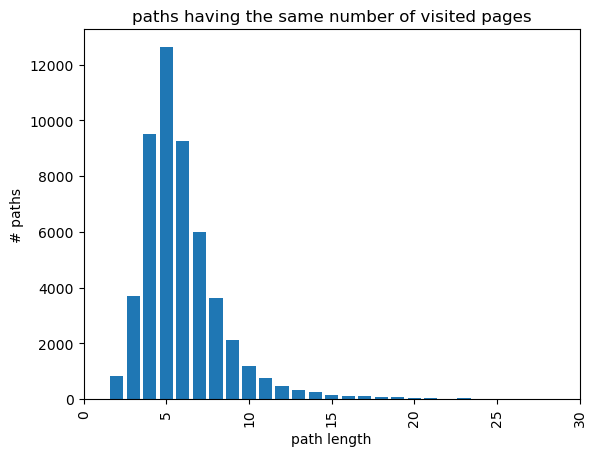

In [17]:
# paths_rank_ : a list of lists that containsall the paths padded with 0 at the end so that they have he same length
paths_rank_=[]

m=407

for i, s in finished_paths.iterrows():
    path_split = (finished_paths['path'].iloc[i]).split(';')

    path_split = remove_unvisited_pages(path_split)

    for j in range(len(path_split)):
        path_split[j] = page_rank.get(path_split[j], -1)

        
    if (len(path_split) < m):
        tmp = [0]*(m-len(path_split))

        path_split = path_split+tmp
        
        
    paths_rank_.append(path_split)
    

    
# paths_rank_df is dataframe that contains all finished paths where each article is represented by its page rank
paths_rank_df = pd.DataFrame(paths_rank_)


counter_path_length = paths_rank_df.apply(lambda x: (x!=0).sum(),axis=1)
frequencies_length = counter_path_length.value_counts()
paths_rank_df['length']= counter_path_length

# plot the number of paths having the same number of visited pages
plt.bar(frequencies_length.index,frequencies_length.values)
plt.xticks(rotation=90)
plt.title('paths having the same number of visited pages')
plt.ylabel('# paths')
plt.xlabel('path length')
plt.xlim(0,30)
plt.show()



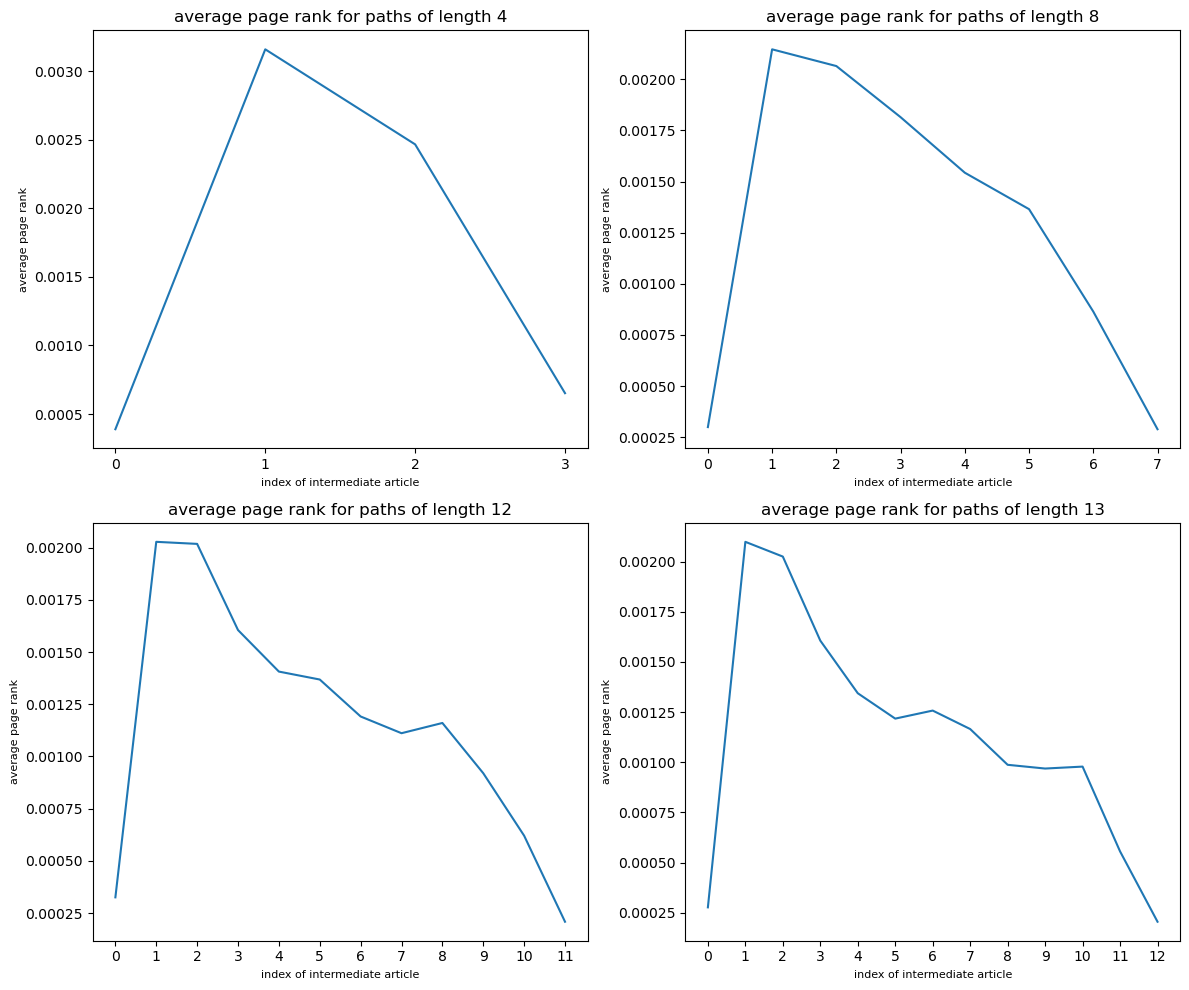

In [18]:
fig, axs = plt.subplots(2,2, figsize=(12,10))

len_ = 4
paths_fixed_len = paths_rank_df.copy()[paths_rank_df['length']==len_]
columns_to_drop = paths_fixed_len.columns[len_:]
new_paths_fixed_len = paths_fixed_len.drop(columns_to_drop, axis = 1)
x = new_paths_fixed_len.mean(axis=0)
x_vals = np.arange(len(x))
axs[0,0].plot(x.values)
axs[0,0].set_xticks(x_vals)
axs[0,0].set_xlabel('index of intermediate article', fontsize=8)
axs[0,0].set_title('average page rank for paths of length %d'%len_)
axs[0,0].set_ylabel('average page rank', fontsize=8)



len_ = 8
paths_fixed_len = paths_rank_df.copy()[paths_rank_df['length']==len_]
columns_to_drop = paths_fixed_len.columns[len_:]
new_paths_fixed_len = paths_fixed_len.drop(columns_to_drop, axis = 1)
x = new_paths_fixed_len.mean(axis=0)
axs[0,1].set_xlabel('index of intermediate article', fontsize=8)
axs[0,1].plot(x.values)
x_vals = np.arange(len(x))
axs[0,1].set_xticks(x_vals)
axs[0,1].set_title('average page rank for paths of length %d'%len_)
axs[0,1].set_ylabel('average page rank',  fontsize=8)



len_ = 12
paths_fixed_len = paths_rank_df.copy()[paths_rank_df['length']==len_]
columns_to_drop = paths_fixed_len.columns[len_:]
new_paths_fixed_len = paths_fixed_len.drop(columns_to_drop, axis = 1)
x = new_paths_fixed_len.mean(axis=0)
axs[1,0].plot(x.values)
axs[1,0].set_title('average page rank for paths of length %d'%len_)
axs[1,0].set_ylabel('average page rank',  fontsize=8)
axs[1,0].set_xlabel('index of intermediate article', fontsize=8)

x_vals = np.arange(len(x))
axs[1,0].set_xticks(x_vals)



len_ = 13
paths_fixed_len = paths_rank_df.copy()[paths_rank_df['length']==len_]
columns_to_drop = paths_fixed_len.columns[len_:]
new_paths_fixed_len = paths_fixed_len.drop(columns_to_drop, axis = 1)
x = new_paths_fixed_len.mean(axis=0)
axs[1,1].plot(x.values)
axs[1,1].set_xlabel('index of intermediate article', fontsize=8)
axs[1,1].set_ylabel('average page rank', fontsize=8)
x_vals = np.arange(len(x))
axs[1,1].set_xticks(x_vals)
axs[1,1].set_title('average page rank for paths of length %d'%len_)

fig.tight_layout()
plt.show()

Discussion about the big jump :

the slow fall 

define UP PATH DOWN PATH notions 


### Part 2- Uncovering User Semantical links :

- talk about how users htink in categories and general semantical fields more than specific articles 
- we try to prove that but first we need to talk about the categories 
- we will analyze the categories, 
- make the paths of articles into paths of categories 
- see the connection between links in heatmap

###### Now we would like to consider the categories ....

In [19]:
categories.head()

,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists


129  different categories


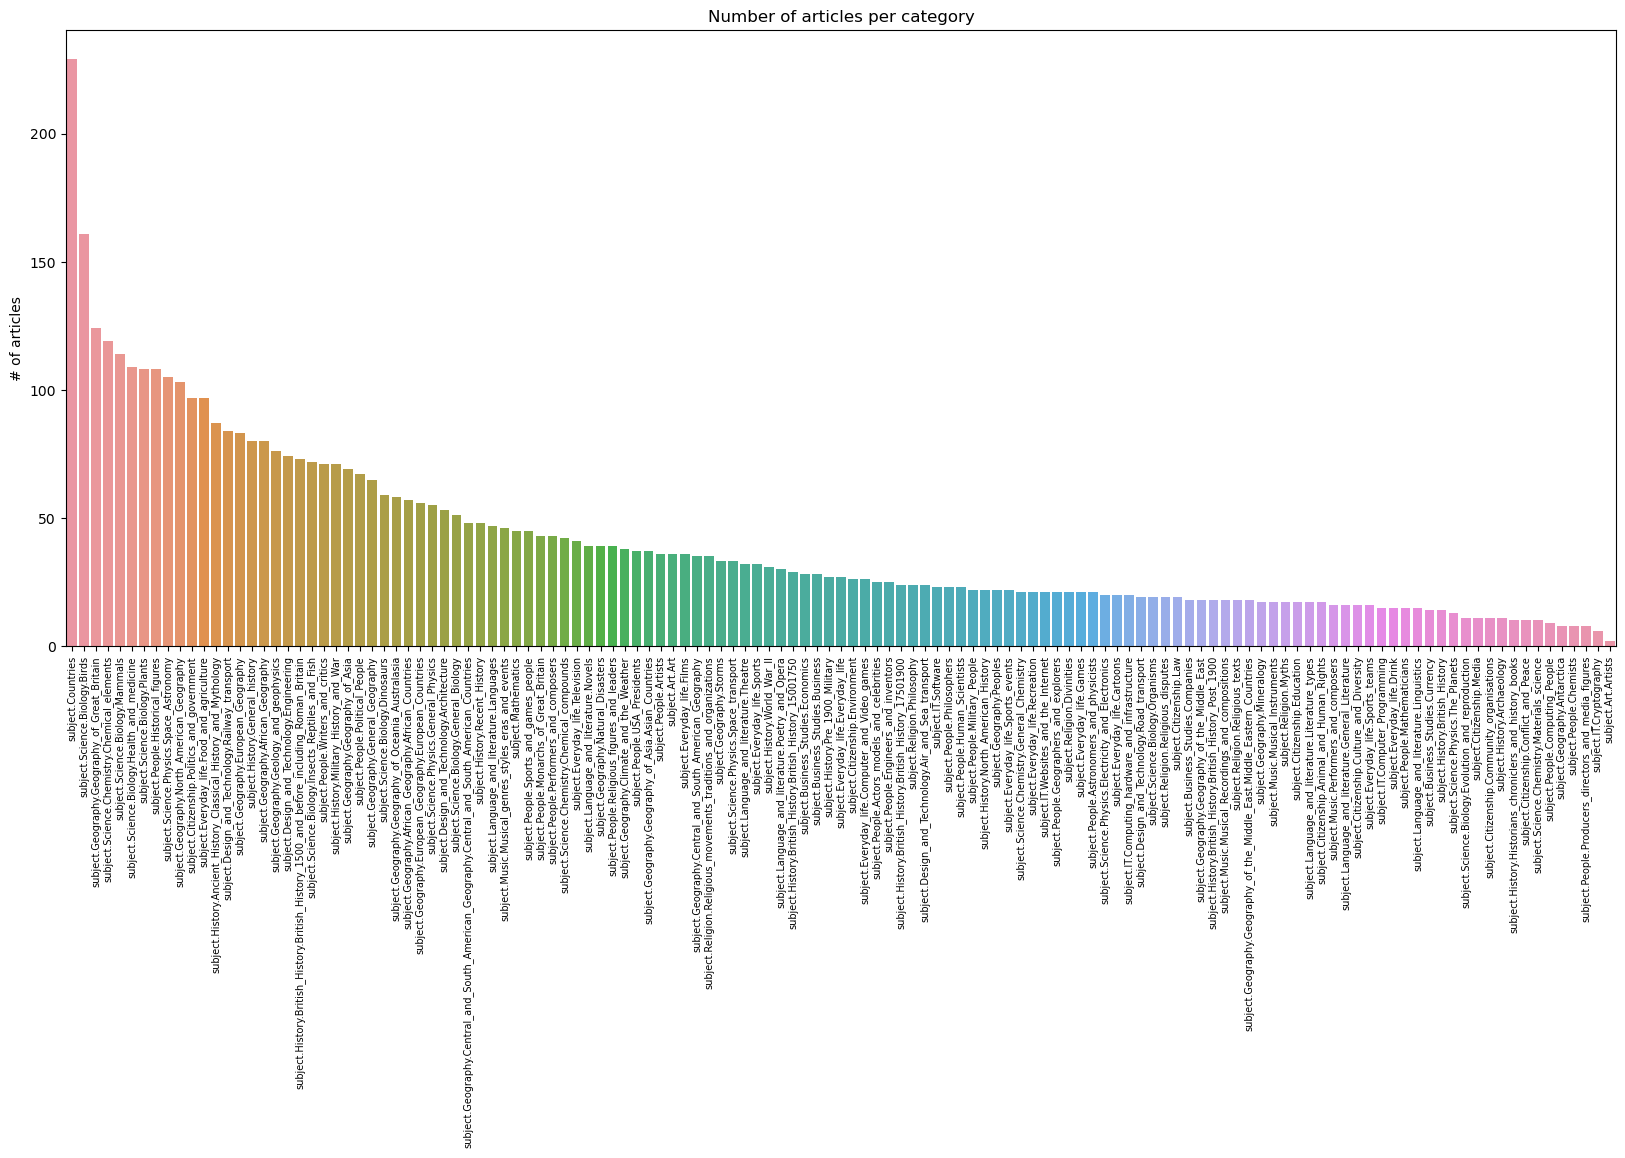

In [20]:
unique_categories = categories['category'].drop_duplicates()
print(len(unique_categories), ' different categories')

freq = categories['category'].value_counts()

plt.figure(figsize=(20, 8))
sns.barplot(x=freq.index, y=freq.values, width = 0.8)
plt.xticks(rotation=90, fontsize=7)
plt.title('Number of articles per category')
plt.ylabel('# of articles')
plt.show()

In [21]:
#aux
# The number of periods is the specifity of the category, the more specific, the more relevant 
def count_periods(s):
    return s.count('.')

In [22]:
# Column with the count of periods in the category
categories['period_count'] = categories['category'].apply(count_periods)

# Most specific category for each article
most_specific_category = categories.sort_values(by='period_count', ascending=False).drop_duplicates('article')
specific_categories = most_specific_category.drop(columns=['period_count'])

# Reseting the index
specific_categories.reset_index(drop=True, inplace=True)

specific_categories.head()

,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,European_Greenfinch,subject.Science.Biology.Birds
2,Rutherfordium,subject.Science.Chemistry.Chemical_elements
3,Eurasian_Oystercatcher,subject.Science.Biology.Birds
4,Eurasian_Jay,subject.Science.Biology.Birds


In [23]:
# Making the article column the index
specific_categories = specific_categories.set_index('article')

In [24]:
specific_categories.head()

,category
article,
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
European_Greenfinch,subject.Science.Biology.Birds
Rutherfordium,subject.Science.Chemistry.Chemical_elements
Eurasian_Oystercatcher,subject.Science.Biology.Birds
Eurasian_Jay,subject.Science.Biology.Birds


In [25]:
#categories of the top articles 
categories_of_top_articles = []
for a in top_articles:
    c = categories[categories['article']==a]['category'].tolist()

    # remove the categry 'subject.Countries' as all pages that have this category have other ones more specific like Geography.Asian/eurpean coutries
    c_p = [elem for elem in c if elem!= 'subject.Countries']

    categories_of_top_articles+=c_p

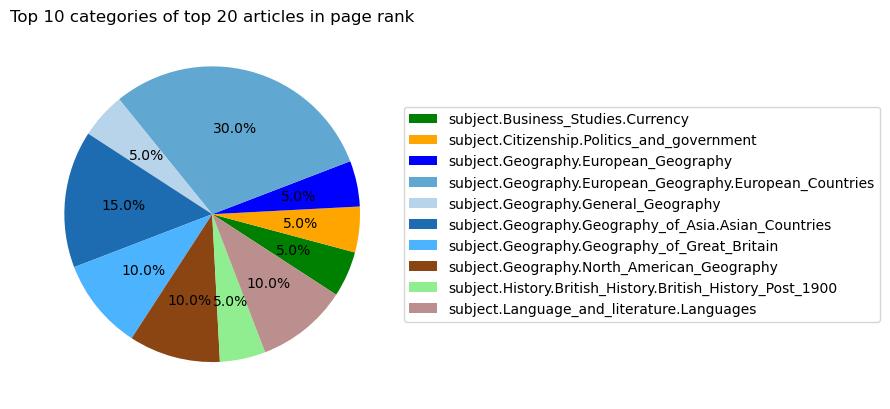

In [26]:
# show the most recurrent categories for top ranked pages

x=np.array(list(Counter(categories_of_top_articles).keys()))
y=np.array(list(Counter(categories_of_top_articles).values()))
#sort categories of top ranked articles
idx_sorted = np.argsort(x)
x_sorted = x[idx_sorted]
y_sorted = y[idx_sorted]

#plot pie chart
plt.pie(y_sorted[:10], autopct='%1.1f%%', startangle=-33, colors=['green', 'orange','blue','#60a7d2','#b7d4ea','#1d6cb1', '#4cb3ff',  'saddlebrown','#90EE90', 'rosybrown'])
plt.title('Top 10 categories of top 20 articles in page rank')
plt.legend( labels=x_sorted[:10],loc='center left', bbox_to_anchor=(1,0.5))
plt.show()

We observe that top ranked articles have categories mainly_ Countries, geography, history, science. This suggest that will have high traffic through those categories. Also we expect the hubs to be mostly part of those categories.

### Linking paths and categories

In [27]:
# removes unvisited pages and seperate each path into UpPath and DownPath
def process_paths(paths,processed_paths,pages_with_no_rank,upPath = True) :
    for i, s in paths.iterrows():
        path_split=(paths['path'].iloc[i]).split(';')
        path_split = remove_unvisited_pages(path_split)
        ranks = []
        for elem in path_split:
            r = page_rank.get(elem, -1)
            if r==-1:
                pages_with_no_rank.append(elem)
            ranks.append(r)
        if upPath : 
            processed_paths.append(path_split[:np.argmax(ranks)])
        else : 
            processed_paths.append(path_split[np.argmax(ranks) :])


In [28]:

# processed paths contains all the paths starting from the 'hub'  or up to the 'hub' depending if it is upPath or downPath
processed_finished_paths_upPath = []
pages_with_no_rank_finished_paths_upPath = []  # those pages are missing in 'articles' 
process_paths(finished_paths,processed_finished_paths_upPath,pages_with_no_rank_finished_paths_upPath)  

processed_finished_paths_downPath = []
pages_with_no_rank_finished_paths_downPath = []  # those pages are missing in 'articles' 
process_paths(finished_paths,processed_finished_paths_downPath,pages_with_no_rank_finished_paths_downPath, upPath=False)  


processed_unfinished_paths_upPath = []
pages_with_no_rank_unfinished_paths_upPath = []  #  pages are missing in 'articles' 
process_paths(unfinished_paths,processed_unfinished_paths_upPath,pages_with_no_rank_unfinished_paths_upPath)  

processed_unfinished_paths_downPath = []
pages_with_no_rank_unfinished_paths_downPath = []  #  pages are missing in 'articles' 
process_paths(unfinished_paths,processed_unfinished_paths_downPath,pages_with_no_rank_unfinished_paths_downPath, upPath=False)  

### 2 - Analyse finished Paths Behavior
## ************************************************************************************************************************

### 2-1 Finished Paths - UpPath

In this part , we will  be directed towards the "Up Paths" segment of the succesfully finished paths. Specifically, we will utilize all the transitions leading up to the hub (estimated as the article with  the maximum page rank score) for each path. This information was previously calculated in the preceding section. Our objective here is to confirm whether the trend within this initial portion of the transitions involves links from a specific category to a more general one, in order to attain some hub.

In [29]:
#aux
# building the connection dataframe with the counter
def build_category_connections(category_paths) :
    category_pairs_counter = defaultdict(int)

    # Process each path
    for path in category_paths:
        for i in range(len(path) - 1):
            # Increment the counter for each found pair
            pair = (path[i], path[i + 1])
            category_pairs_counter[pair] += 1

    # unique category list that appear in our paths, 
    # no need for all categories of articles in  

    unique_categories = list(set(cat for path in category_paths for cat in path))

    # Initialize an the connections
    category_connections = pd.DataFrame(index=unique_categories, columns=unique_categories).fillna(0)

    # filling up the values with the counts
    for (cat1, cat2), count in category_pairs_counter.items():
        category_connections.loc[cat1, cat2] = count
    
    return category_connections

In [30]:
#aux
def count_words(index):
    return len(index.split('.'))

In [31]:
#aux
def heatmap_general_categories(category_connections) :
    df = category_connections.copy() 
    df = df.drop(index = "Unknown_Category")
    df = df.drop(columns = "Unknown_Category")
    df = df.fillna(0)
    #Remove 'subject.' prefix since it is common to all categories
    prev_list = [ li  for li in df.columns]
    
    unique_vals = list(set(stri.split('.')[1] for stri in df.index))
    print(unique_vals)
    final_df = pd.DataFrame(index = unique_vals, columns = unique_vals)
    final_df = final_df.fillna(0)
    

    for ind1,row1 in df.iterrows() :
        for value in prev_list :
            final_df.loc[ind1.split('.')[1],value.split('.')[1]] =  final_df.loc[ind1.split('.')[1],value.split('.')[1]] + row1[value]
    # Replacing diagonal elements with 0
    rows, cols = final_df.shape
    for i in range(rows):
        final_df.iloc[i, i] = 0        
    

    final_df = final_df.div(final_df.sum(axis=1), axis=0)    
    #plotting the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(final_df, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True)
    plt.title('Heatmap of Weights between Categories')
    plt.show()   
    return final_df

In [32]:
#aux
#Now we can also focus only on categories that belong to a  General Category such as Science or History... 
def heatMap_Special_Category(category,category_connections) : 
    
    df = category_connections.copy() 
    
    #Remove 'subject.' prefix again
    df.index = df.index.str.replace('subject.', '')
    df.columns = df.columns.str.replace('subject.', '')
    #filtering   all the categories to keep only those that belong to the general one
    df = df.filter(like=category, axis=1).filter(like=category, axis=0)
    
    #Again dropping all the diagonal values for the same reasons as before
    np.fill_diagonal(df.values, 0)
    df = df.div(df.sum(axis=1), axis=0)
    #Plotting the heatMap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True)
    plt.title('Heatmap of Weights between Categories of %s' %category)
    plt.show()   

In [33]:
# transforming the article paths into paths of categories for the UpPath Part of the finished paths 
processed_finished_paths_serie = pd.Series(processed_finished_paths_upPath)
category_finished_paths_upPath = processed_finished_paths_serie.map(lambda path: [specific_categories.loc[article, 'category'] if article in specific_categories.index else 'Unknown_Category' for article in path])
category_finished_paths_upPath.head()

0                    [subject.History.General_history]
1    [subject.History.General_history, subject.Geog...
2    [subject.History.General_history, subject.Hist...
3                    [subject.History.General_history]
4    [subject.History.General_history, subject.Geog...
dtype: object

In [34]:
# build category connections for uppath categories 
category_connections_finished_paths_upPath = build_category_connections(category_finished_paths_upPath)
category_connections_finished_paths_upPath

,subject.Geography.Peoples,subject.Everyday_life.Sports_events,subject.History.General_history,subject.Language_and_literature.Literature_types,subject.People.Engineers_and_inventors,subject.Language_and_literature.Theatre,subject.Everyday_life.Television,subject.Design_and_Technology.Railway_transport,subject.Science.Biology.Health_and_medicine,subject.Religion.Myths,...,subject.IT.Computing_hardware_and_infrastructure,subject.Language_and_literature.Linguistics,subject.History.Ancient_History_Classical_History_and_Mythology,subject.People.Mathematicians,subject.Everyday_life.Sports_teams,subject.History.Recent_History,subject.Geography.Mineralogy,subject.Design_and_Technology.Road_transport,subject.People.Religious_figures_and_leaders,subject.Citizenship.Law
subject.Geography.Peoples,0,0,3,0,0,0,0,0,4,0,...,0,1,4,0,0,1,0,1,0,0
subject.Everyday_life.Sports_events,0,20,0,0,0,0,2,0,0,0,...,0,0,2,0,1,1,1,0,0,0
subject.History.General_history,3,0,285,1,1,0,2,1,6,1,...,0,14,32,0,0,1,0,0,12,0
subject.Language_and_literature.Literature_types,1,0,13,17,4,82,0,0,2,148,...,0,0,21,0,0,0,0,0,0,0
subject.People.Engineers_and_inventors,0,0,5,0,2,0,1,2,2,1,...,0,0,0,0,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
subject.History.Recent_History,0,0,1,0,0,0,1,5,3,0,...,2,0,0,2,0,30,1,0,0,2
subject.Geography.Mineralogy,0,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,34,0,0,0
subject.Design_and_Technology.Road_transport,0,0,1,0,7,0,0,0,0,0,...,0,0,0,0,0,0,0,6,0,4
subject.People.Religious_figures_and_leaders,5,0,13,0,0,0,0,0,1,0,...,0,1,1,0,0,0,0,0,16,2


['Language_and_literature', 'Art', 'Music', 'Design_and_Technology', 'History', 'Citizenship', 'Business_Studies', 'Geography', 'People', 'Mathematics', 'Everyday_life', 'Religion', 'IT', 'Science']


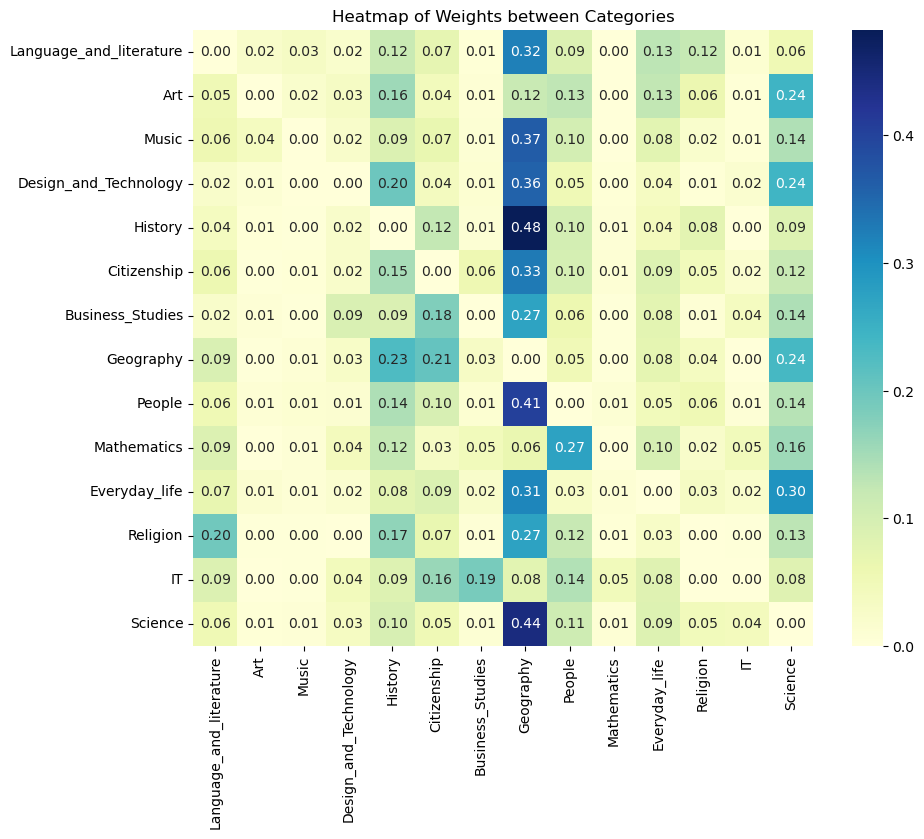

,Language_and_literature,Art,Music,Design_and_Technology,History,Citizenship,Business_Studies,Geography,People,Mathematics,Everyday_life,Religion,IT,Science
Language_and_literature,0.000000,0.024016,0.032192,0.019417,0.117527,0.072560,0.005621,0.321921,0.087890,0.000511,0.129790,0.121104,0.012264,0.055187
Art,0.053846,0.000000,0.020513,0.033333,0.156410,0.043590,0.007692,0.117949,0.128205,0.000000,0.125641,0.064103,0.005128,0.243590
Music,0.057348,0.039427,0.000000,0.023297,0.089606,0.066308,0.010753,0.365591,0.102151,0.001792,0.078853,0.019713,0.005376,0.139785
Design_and_Technology,0.022769,0.009846,0.001846,0.000000,0.198769,0.040615,0.012308,0.356923,0.052923,0.004923,0.035692,0.005538,0.015385,0.242462
History,0.038562,0.005219,0.002030,0.023485,0.000000,0.122644,0.011018,0.482749,0.102349,0.005799,0.043201,0.075964,0.001740,0.085242
Citizenship,0.059410,0.002602,0.005204,0.022984,0.148309,0.000000,0.056808,0.328274,0.098439,0.008673,0.085429,0.045533,0.018647,0.119688
Business_Studies,0.023634,0.005908,0.002954,0.093058,0.091581,0.180207,0.000000,0.273264,0.060561,0.002954,0.076809,0.008863,0.038405,0.141802
Geography,0.092780,0.002388,0.008451,0.027375,0.229836,0.205585,0.031233,0.000000,0.051258,0.002205,0.075142,0.036377,0.000551,0.236818
People,0.055944,0.008288,0.012173,0.014245,0.142968,0.095312,0.012432,0.405335,0.000000,0.010101,0.045843,0.055167,0.006734,0.135457
Mathematics,0.088176,0.000000,0.006012,0.042084,0.124248,0.032064,0.046092,0.064128,0.274549,0.000000,0.096192,0.024048,0.046092,0.156313


In [36]:
# comment
heatmap_general_categories(category_connections_finished_paths_upPath)

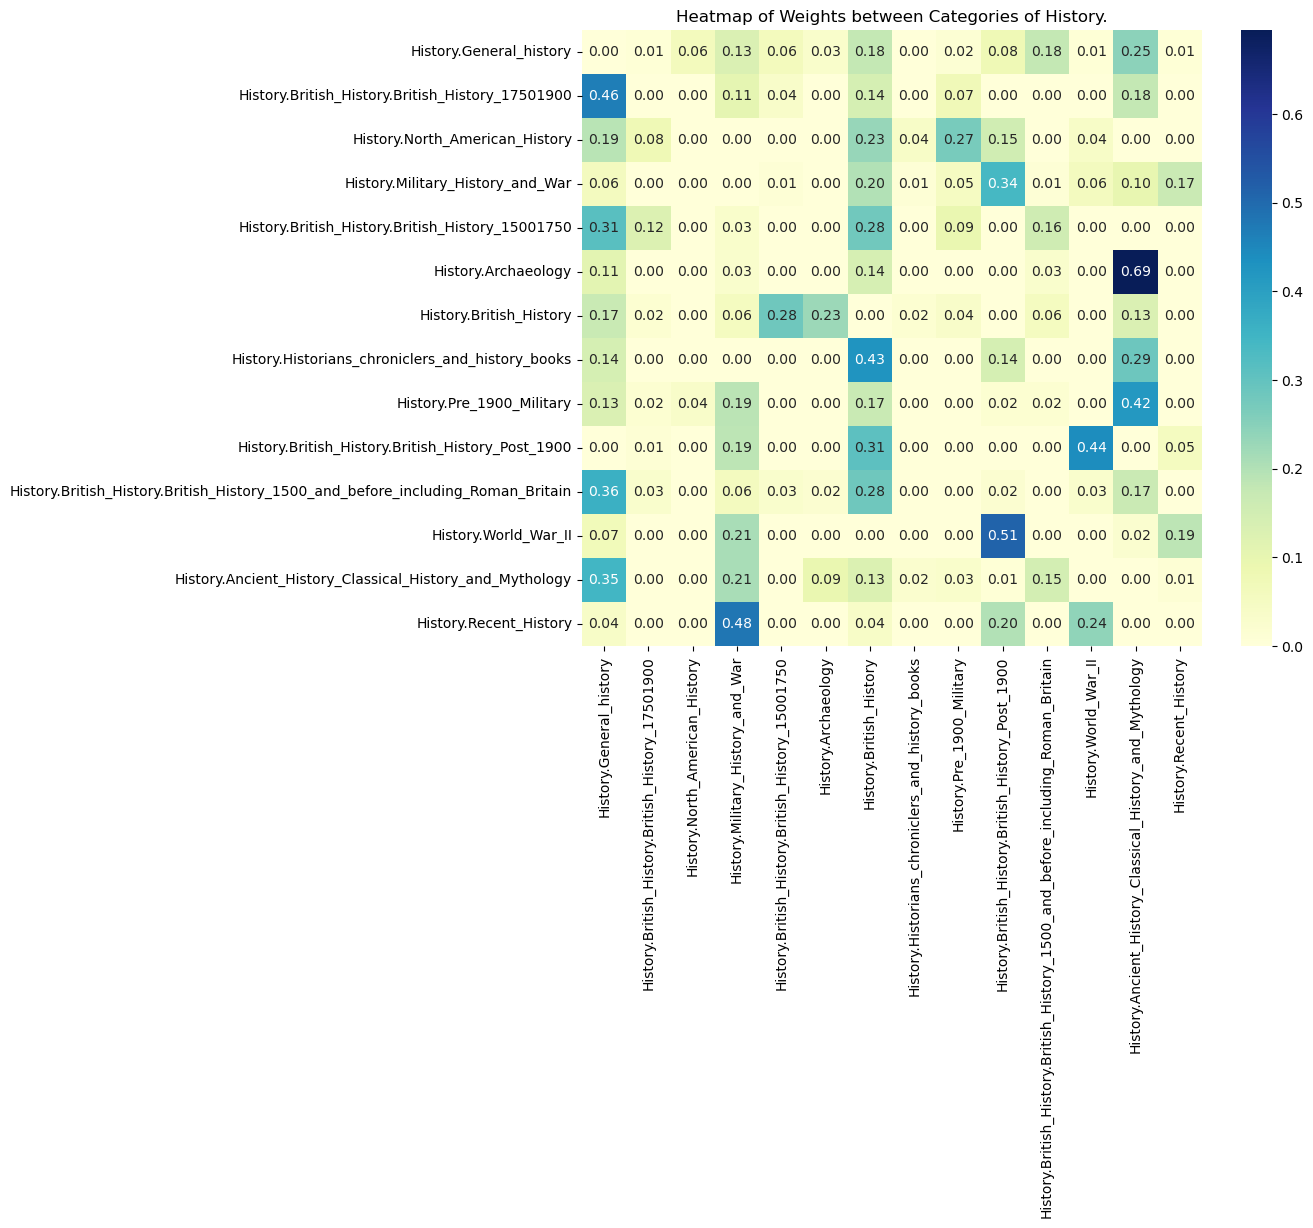

In [37]:
#comment
heatMap_Special_Category("History.",category_connections_finished_paths_upPath)

Discussion

Let's consider the graph of detected communities for the uppath of finished paths

### 2-2 Finished Paths - DownPath

In this part , we will  focus on the "Down Paths" segment of the succesfully finished paths. Specifically, we will utilize all the transitions starting from the hub up to the final destination.Since we disovered in the previous sub-section that the first 'Up Path' segment lead to a general category in general(corresponding to the category of the hub), we will be expecting to find that the Down Path(i.e the second part of the transitions) generally involves links from  general category to a specific one.

In [38]:
# transforming the article paths into paths of categories for the downPath Part of the finished paths 
processed_finished_paths_serie_downPath = pd.Series(processed_finished_paths_downPath)
category_finished_paths_downPath = processed_finished_paths_serie_downPath.map(lambda path: [specific_categories.loc[article, 'category'] if article in specific_categories.index else 'Unknown_Category' for article in path])
print(category_finished_paths_downPath.head(1))

0    [subject.Geography.European_Geography, subject...
dtype: object


In [42]:
# build category connections 
category_connections_finished_paths_downPath = build_category_connections(category_finished_paths_downPath)
category_connections_finished_paths_downPath

,subject.Geography.Peoples,subject.Everyday_life.Sports_events,subject.History.General_history,subject.Language_and_literature.Literature_types,subject.People.Engineers_and_inventors,subject.Language_and_literature.Theatre,subject.Design_and_Technology.Railway_transport,subject.Everyday_life.Television,subject.Science.Biology.Health_and_medicine,subject.Religion.Myths,...,subject.IT.Computing_hardware_and_infrastructure,subject.Language_and_literature.Linguistics,subject.History.Ancient_History_Classical_History_and_Mythology,subject.People.Mathematicians,subject.Everyday_life.Sports_teams,subject.History.Recent_History,subject.Geography.Mineralogy,subject.Design_and_Technology.Road_transport,subject.People.Religious_figures_and_leaders,subject.Citizenship.Law
subject.Geography.Peoples,4,0,4,0,0,0,0,0,3,0,...,0,0,10,0,0,0,0,0,2,0
subject.Everyday_life.Sports_events,0,38,0,1,0,0,0,2,0,0,...,0,0,14,0,2,0,0,0,0,0
subject.History.General_history,11,0,1134,5,15,0,35,17,39,0,...,46,166,55,17,0,16,0,7,12,2
subject.Language_and_literature.Literature_types,0,0,4,64,0,16,0,0,2,83,...,0,0,17,0,0,0,0,0,0,0
subject.People.Engineers_and_inventors,0,0,2,1,7,0,0,0,0,0,...,0,0,0,0,0,0,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
subject.History.Recent_History,2,0,12,0,0,0,0,0,1,0,...,1,0,0,2,0,83,1,0,0,4
subject.Geography.Mineralogy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,71,0,0,0
subject.Design_and_Technology.Road_transport,0,2,0,0,21,0,0,0,0,0,...,0,0,0,0,0,0,0,19,0,2
subject.People.Religious_figures_and_leaders,0,0,3,0,0,0,0,0,1,0,...,0,0,2,0,0,0,0,0,57,0


['Language_and_literature', 'Art', 'Music', 'Design_and_Technology', 'History', 'Citizenship', 'Business_Studies', 'Geography', 'People', 'Mathematics', 'Everyday_life', 'Religion', 'IT', 'Science']


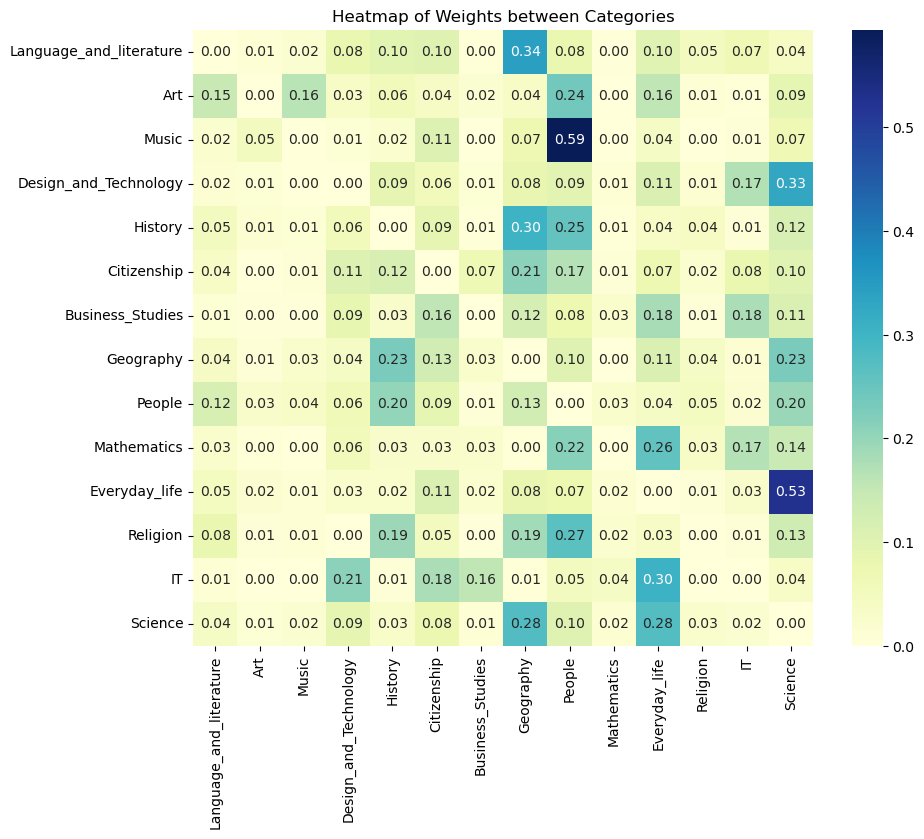

In [43]:
#comment
finished_dP_general_adj = heatmap_general_categories(category_connections_finished_paths_downPath)

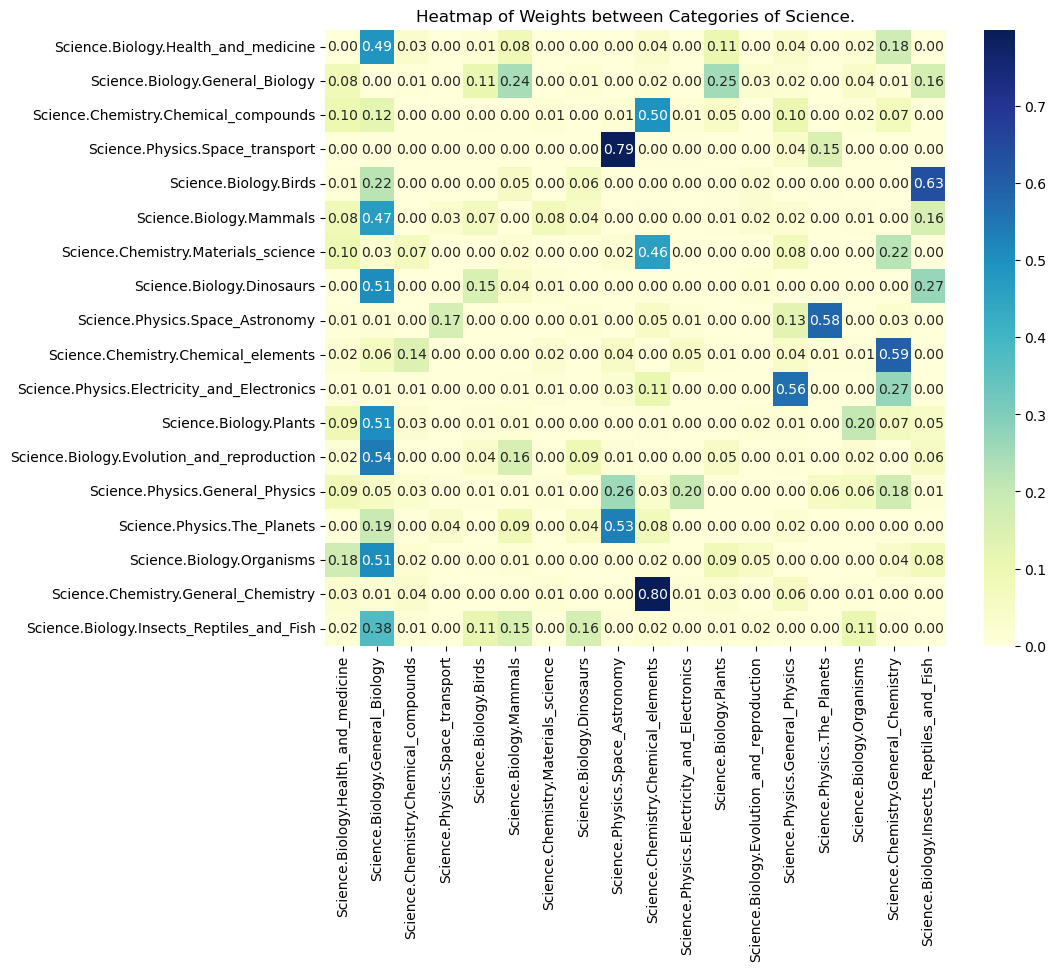

In [44]:
#comment
heatMap_Special_Category("Science.",category_connections_finished_paths_downPath)

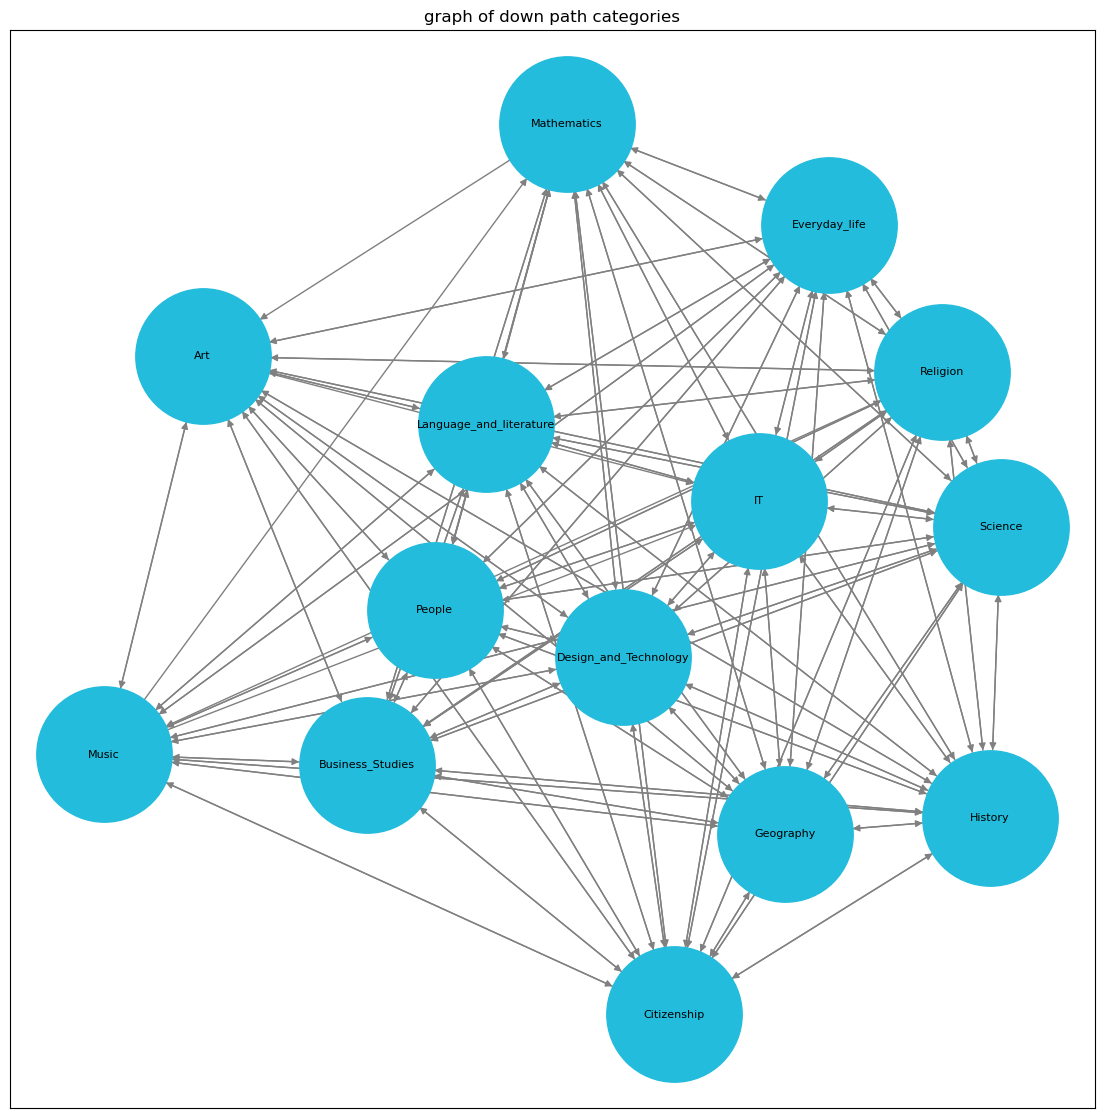

In [70]:
#graph of down path categories in finished paths

G_d= nx.from_pandas_adjacency(finished_dP_general_adj, create_using = nx.DiGraph())

plt.figure(figsize=(14,14))
plt.title('graph of down path categories')
nx.draw_networkx(G_d, edge_color='gray',node_size=9500, font_size=8, node_color='#23bcdc')


Discussion

### 3 - Analyse Unfinished Paths Behavior
## ************************************************************************************************************************

### 3-1 Unfinished Paths - UpPath

In this sub-part, we conduct a similar analysis of the "UpPath" as we did previously for the completed paths, but this time focusing on the unfinished paths. This approach will allow us to  explore the important differences between successful and unsuccessful paths.

In [71]:
# transforming the article paths into paths of categories for the UpPath Part of the unfinished paths 
processed_unfinished_paths_serie = pd.Series(processed_unfinished_paths_upPath)   #check please
category_unfinished_paths_upPath = processed_unfinished_paths_serie.map(lambda path: [specific_categories.loc[article, 'category'] if article in specific_categories.index else 'Unknown_Category' for article in path])
category_unfinished_paths_upPath.head()

0                                                   []
1                                                   []
2    [subject.Geography.African_Geography.African_C...
3                                                   []
4    [subject.Geography.Central_and_South_American_...
dtype: object

In [72]:
#build category connections 
category_connections_unfinished_paths_upPath = build_category_connections(category_unfinished_paths_upPath)
category_connections_unfinished_paths_upPath

,subject.Geography.Peoples,subject.Everyday_life.Sports_events,subject.History.General_history,subject.Language_and_literature.Literature_types,subject.People.Engineers_and_inventors,subject.Language_and_literature.Theatre,subject.Design_and_Technology.Railway_transport,subject.Everyday_life.Television,subject.Science.Biology.Health_and_medicine,subject.Religion.Myths,...,subject.IT.Computing_hardware_and_infrastructure,subject.Language_and_literature.Linguistics,subject.Everyday_life.Sports_teams,subject.People.Mathematicians,subject.History.Ancient_History_Classical_History_and_Mythology,subject.History.Recent_History,subject.Geography.Mineralogy,subject.Design_and_Technology.Road_transport,subject.People.Religious_figures_and_leaders,subject.Citizenship.Law
subject.Geography.Peoples,1,0,1,0,0,0,0,0,0,0,...,0,1,0,0,6,2,0,0,0,0
subject.Everyday_life.Sports_events,0,11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
subject.History.General_history,1,1,118,2,3,0,3,1,4,0,...,0,7,0,0,13,1,0,0,5,1
subject.Language_and_literature.Literature_types,0,0,8,19,2,54,0,0,0,17,...,0,0,0,0,10,0,0,0,0,0
subject.People.Engineers_and_inventors,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
subject.History.Recent_History,0,0,2,0,0,0,1,0,1,0,...,0,0,0,0,0,12,1,0,0,1
subject.Geography.Mineralogy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,10,0,0,0
subject.Design_and_Technology.Road_transport,0,2,1,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,4,0,0
subject.People.Religious_figures_and_leaders,2,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0


['Language_and_literature', 'Art', 'Music', 'Design_and_Technology', 'History', 'Citizenship', 'Business_Studies', 'Geography', 'People', 'Mathematics', 'Everyday_life', 'Religion', 'IT', 'Science']


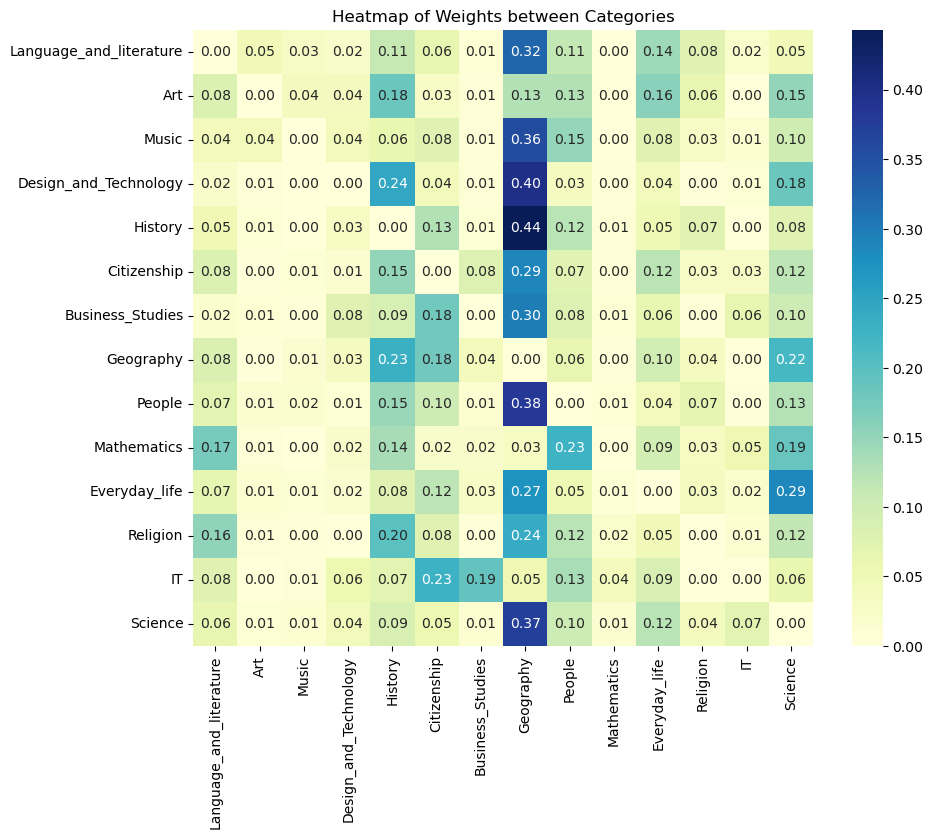

In [74]:
tmp = heatmap_general_categories(category_connections_unfinished_paths_upPath)

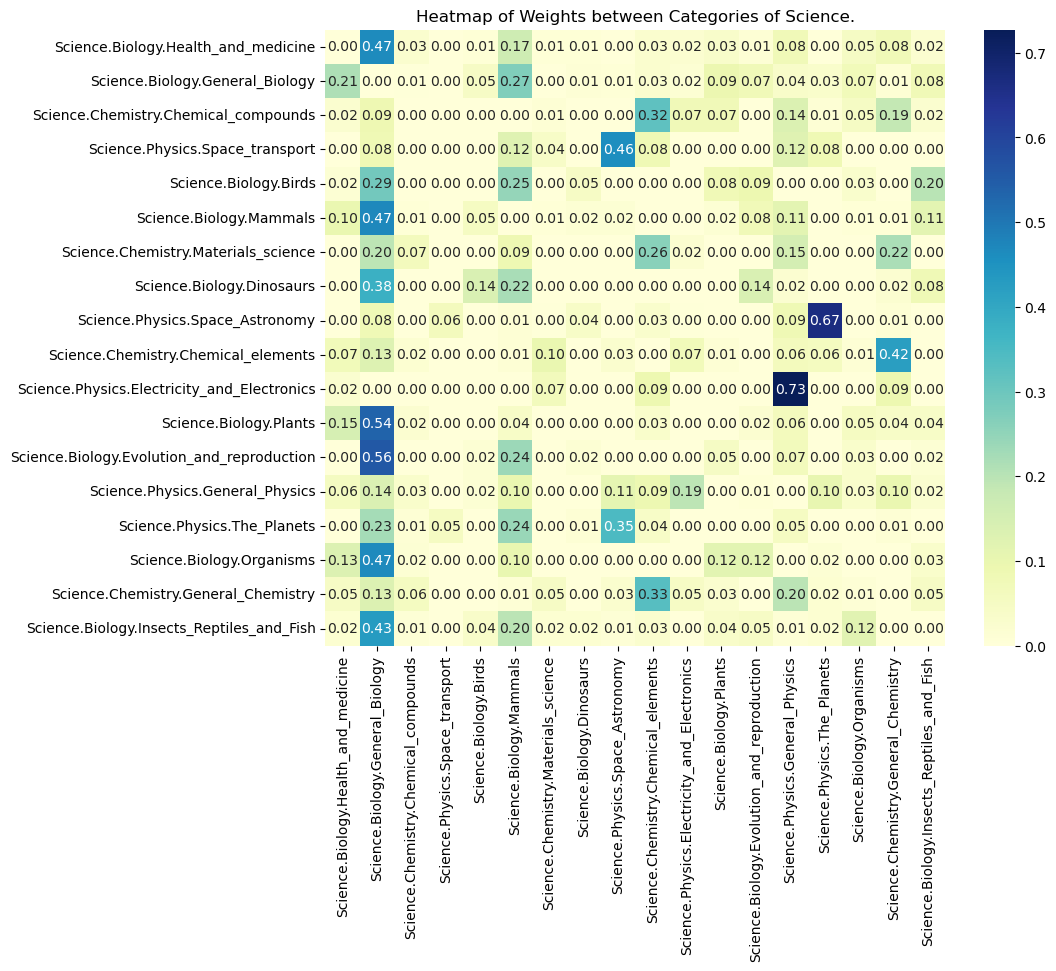

In [75]:
heatMap_Special_Category("Science.",category_connections_unfinished_paths_upPath)

### 3-2 Unfinished Paths - DownPath

In this subsection , We will conduct the same analysis for the DownPath of the  unfinished paths as we did for the finished paths. Given that we observed the same behavior in both paths for the UpPath segment during the previous subsection, we expect that the finished and unfinished paths both have the same behavior also for the DownPath, which means that we will observe links generally going from a general category to a more specific one.

In [76]:
# transforming the article paths into paths of categories  
processed_unfinished_paths_serie = pd.Series(processed_unfinished_paths_downPath)
category_unfinished_paths_downPath = processed_unfinished_paths_serie.map(lambda path: [specific_categories.loc[article, 'category'] if article in specific_categories.index else 'Unknown_Category' for article in path])
category_unfinished_paths_downPath.head()

0                        [subject.Everyday_life.Films]
1                  [subject.People.Historical_figures]
2    [subject.Citizenship.Politics_and_government, ...
3    [subject.Geography.Central_and_South_American_...
4    [subject.Geography.Central_and_South_American_...
dtype: object

In [77]:
#Build category connections
category_connections_unfinished_paths_downPath = build_category_connections(category_unfinished_paths_downPath)
category_connections_unfinished_paths_downPath

,subject.Geography.Peoples,subject.Everyday_life.Sports_events,subject.History.General_history,subject.Language_and_literature.Literature_types,subject.People.Engineers_and_inventors,subject.Language_and_literature.Theatre,subject.Everyday_life.Television,subject.Design_and_Technology.Railway_transport,subject.Science.Biology.Health_and_medicine,subject.Religion.Myths,...,subject.IT.Computing_hardware_and_infrastructure,subject.Language_and_literature.Linguistics,subject.History.Ancient_History_Classical_History_and_Mythology,subject.People.Mathematicians,subject.Everyday_life.Sports_teams,subject.History.Recent_History,subject.Geography.Mineralogy,subject.Design_and_Technology.Road_transport,subject.People.Religious_figures_and_leaders,subject.Citizenship.Law
subject.Geography.Peoples,0,0,2,0,0,0,0,0,4,0,...,0,0,5,0,0,0,0,0,0,0
subject.Everyday_life.Sports_events,0,21,0,1,0,0,2,0,0,0,...,0,0,4,0,0,0,0,0,0,0
subject.History.General_history,3,0,280,3,1,0,10,16,13,0,...,5,46,16,1,0,2,0,1,9,2
subject.Language_and_literature.Literature_types,0,0,10,48,2,27,0,0,0,47,...,0,0,7,0,0,0,0,0,0,0
subject.People.Engineers_and_inventors,0,0,1,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
subject.History.Recent_History,1,0,10,0,0,0,0,0,2,0,...,2,0,0,0,0,35,0,0,0,5
subject.Geography.Mineralogy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,16,0,0,0
subject.Design_and_Technology.Road_transport,0,2,0,0,12,0,0,0,0,0,...,0,0,0,0,0,0,0,10,0,4
subject.People.Religious_figures_and_leaders,0,0,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12,0


['Language_and_literature', 'Art', 'Music', 'Design_and_Technology', 'History', 'Citizenship', 'Business_Studies', 'Geography', 'People', 'Mathematics', 'Everyday_life', 'Religion', 'IT', 'Science']


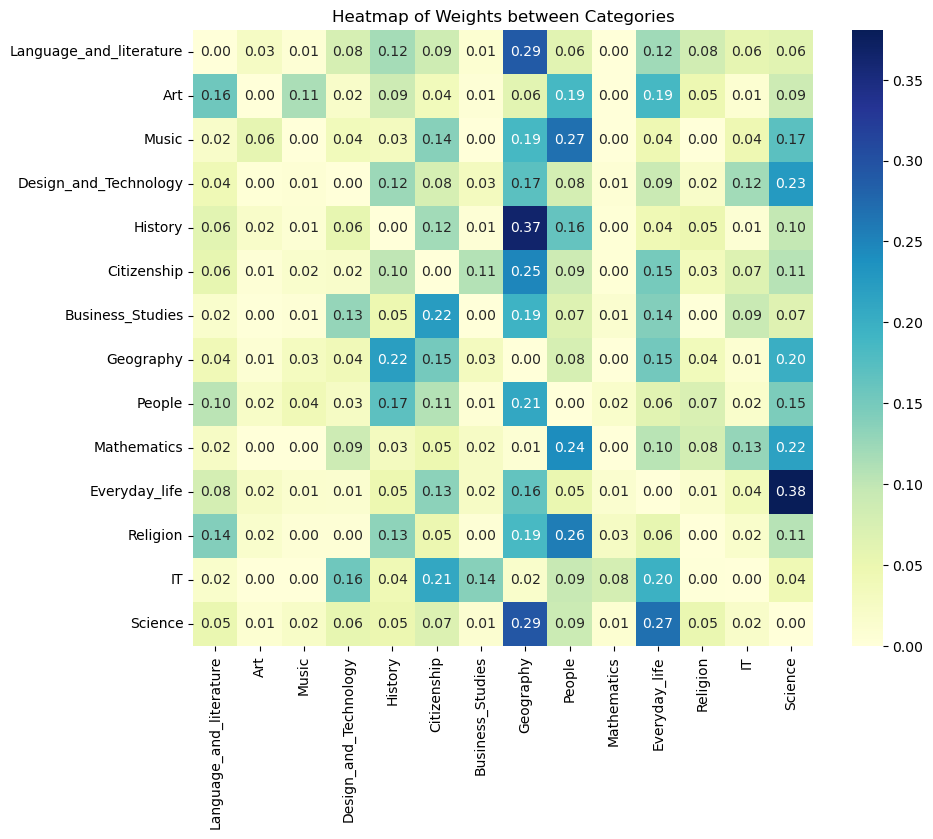

In [80]:
# show haetmap for category_connections of unfinished_paths  - downPath
t2 = heatmap_general_categories(category_connections_unfinished_paths_downPath)

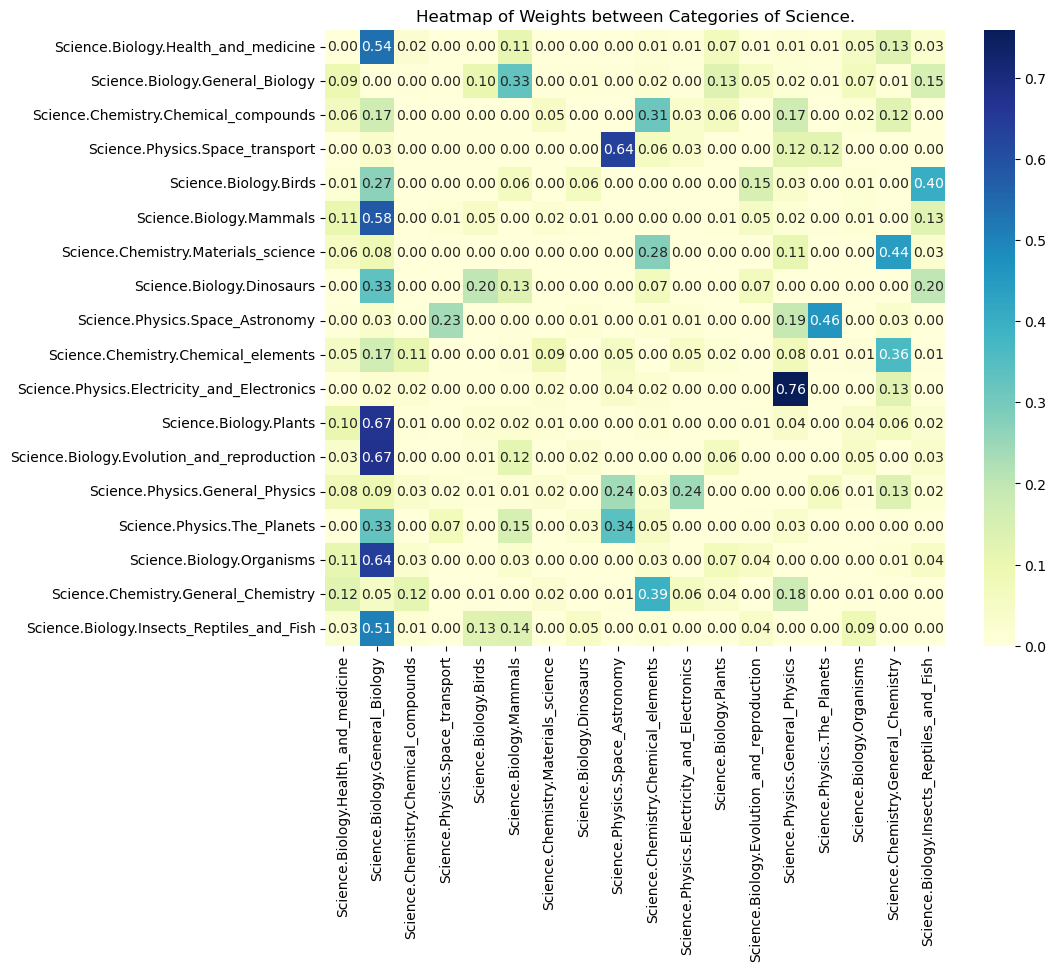

In [82]:
# show haetmap for the category: Science of unfinished_paths  - downPath
heatMap_Special_Category("Science.",category_connections_unfinished_paths_downPath)

#### 4 - Compare destinations of finished and unfinished Paths
## ************************************************************************************************************************

### part 3

In the previous part, we observed that both finished and unfinshed paths have exactly the same pattern : i.e  the first segment (UpPath) of the path

generaly escapes from specific categories to more general ones, up until  a hub, then the second segment(DownPath) links have tendency to go from general categories to more specific ones ,  this suggests that the difference between finished and unfinshed paths is not really the starting point , since we can reach a hub starting from anyhub, but the main difference might be in the final destination article, in this section we will try to analyse differences between the destinations of both finished and unfinished paths by comparing the distribution of their in-degrees.
    

In [83]:
G = articles_graph
#we recover all the in-degrees of the destinations of the unfinished paths
unfinished_paths_in_degrees = unfinished_paths["target"].apply(lambda t: G.in_degree(t)).fillna(0).apply(lambda t : t if isinstance(t, (int)) else 0) + 1 
#we recover all the in-degrees of the destinations of the finished paths
finished_paths_in_degrees = finished_paths["path"].apply(lambda t : G.in_degree(t.split(";")[-1])).apply(lambda t : t if isinstance(t, (int)) else 0) +1


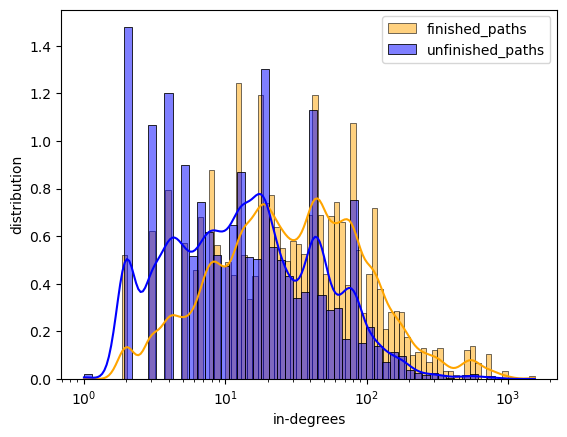

In [84]:
# plotting the distributions of the in-degrees of destinations for both finished and unfinished_paths
ax = sns.histplot(finished_paths_in_degrees, kde=True, stat='density', color='orange', label='finished_paths',log_scale=True)
ax = sns.histplot(unfinished_paths_in_degrees, kde=True, stat='density', color='blue', label='unfinished_paths',log_scale=True)
plt.legend()
plt.ylabel("distribution")
plt.xlabel("in-degrees")
plt.show()

In this histogram, it is clear  that the destinations of unfinished paths are more likely to have lower in-degrees, indicating greater difficulty in reaching those destinations. Also, we can see that  starting from an in-degree of 20 degrees, the destinations of finished paths have a  higher probability. This observation aligns with intuition, as higher in-degrees suggest increased popularity of an article, making it more accessible and easier to reach.

In [51]:
def build_category_connections_unsuccessful(unfinished_paths_categories, targets_categories):
    category_pairs_counter = defaultdict(int)
    # Process each path
    for path_index, path in enumerate(unfinished_paths_categories):
        target_category = targets_categories[path_index]
        for i in range(len(path) - 1):
            # Increment the counter for each found pair
            pair = (path[i], path[i + 1])
            category_pairs_counter[pair] += 1
            # Decrement the counter between this pair and the end category 
            category_pairs_counter[(path[i], target_category)] -= 1

    # unique category list that appear in our paths, 
    # no need for all categories of articles  
    unique_categories = list(set(cat for path in unfinished_paths_categories for cat in path)| set(targets_categories))
    
    # Initialize an the connections
    category_connections = pd.DataFrame(index=unique_categories, columns=unique_categories).fillna(0)

    # filling up the values with the counts
    for (cat1, cat2), count in category_pairs_counter.items():
        category_connections.loc[cat1, cat2] = count
    
    return category_connections

//TODO ABDESS

I checked but I may be wrong : 
the target links are the same order as the initial links 


In [52]:
# transforming the article paths into paths of categories  
unsuccessful_downpaths = pd.Series(processed_unfinished_paths_downPath)
category_unfinished_paths_downPath = processed_unfinished_paths_serie.map(lambda path: [specific_categories.loc[article, 'category'] if article in specific_categories.index else 'Unknown_Category' for article in path])
targets_categories = unfinished_paths["target"]
fixed_unfinished_connections = build_category_connections_unsuccessful(category_unfinished_paths_downPath, targets_categories)

//TODO : Discuss 
Note on execution The problem here is that we have too many columns, every target comes with his own obscure category, (nearly 30000 categories added impossible to visualize) this needs to be handled in some way :
- Alternative: just decrement the connection making the entries into a relevance score towards finding the objective and not simply a connection score  (simple 1 line change, decrement the connection for every connection we see since it wasn't able to bring us to the objective)

In [53]:
# heatmap_general_categories(fixed_unfinished_connections , UpPath = False)

## Model for predicting the success of a  path : Page rank based model 

Intuition : if the logical behavior isn't what matters after all then we can determine the success of a path only based of the "importance" of the articles and how well connected they are in the wikipedia graph (page rank score), we also saw that the UP PATH doesn't matter as much for classifying the paths since both successful and unsuccessful paths have the same in the  => We focus our analyisis on the DOWN PATH


In [92]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler


unique_ips = pd.concat([finished_paths["hashedIpAddress"],unfinished_paths["hashedIpAddress"]]).unique()
dicti = {key: 0 for key in unique_ips}
for indx,row in finished_paths.iterrows() :
    dicti[row["hashedIpAddress"]] +=1
for indx,row in unfinished_paths.iterrows() :
    dicti[row["hashedIpAddress"]] +=1
p1 = finished_paths["hashedIpAddress"].apply(lambda t : dicti[t] if t in dicti.keys() else 0)        
p1
p2 = unfinished_paths["hashedIpAddress"].apply(lambda t : dicti[t] if t in dicti.keys() else 0) 

In [93]:
# Getting the targets
finished_targets = finished_paths["path"].apply(lambda path : path.split(';')[-1])

unfinished_targets = unfinished_paths["target"]

# Associating targets to their page ranks 
finished_targets_rank = finished_targets.apply(lambda target : page_rank.get(target, 0))
unfinished_targets_rank = unfinished_targets.apply(lambda target : page_rank.get(target, 0))

# Associating targets to their specifity
finished_targets_specificity = finished_targets.apply(lambda target: specific_categories.loc[target].category.split(".")[1] if target in specific_categories.index else "unknown")
unfinished_targets_specificity = unfinished_targets.apply(lambda target: specific_categories.loc[target].category.split(".")[1] if target in specific_categories.index else "unknown")

# Labeling the targets
finished_data = pd.DataFrame({'target_rank': finished_targets_rank, 'label': 1})
unfinished_data = pd.DataFrame({'target_rank': unfinished_targets_rank, 'label': 0})

# Combining the data 
combined_data = pd.concat([finished_data, unfinished_data])

In [94]:
# Rescale the 'target_rank' column
y = combined_data['label']
X= combined_data.drop(columns=["label"])  
G = articles_graph
unfinished_paths_in_degrees = unfinished_paths["target"].apply(lambda t: G.in_degree(t)).fillna(0).apply(lambda t : t if isinstance(t, (int)) else 0) + 1 
#we recover all the in-degrees of the destinations of the finished paths
finished_paths_in_degrees = finished_paths["path"].apply(lambda t : G.in_degree(t.split(";")[-1])).apply(lambda t : t if isinstance(t, (int)) else 0) +1
X["indegrees"] = pd.concat([finished_paths_in_degrees,unfinished_paths_in_degrees])
X = (X - X.mean())/X.std()
X["num_of_games"] = pd.concat([p1,p2])

#X["category"] = pd.concat([finished_targets_specificity,unfinished_targets_specificity])
#X = pd.get_dummies(X,columns = ["category"])
# Splitting into train andtest datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train

,target_rank,indegrees,num_of_games
371,-0.443886,-0.362368,61
33856,-0.522977,-0.492798,6
6636,-0.213051,-0.134116,172
37870,-0.552582,-0.503667,21
15878,0.515319,0.333257,60
...,...,...,...
37194,-0.031237,-0.014556,2
6265,-0.476276,-0.449321,7
3569,-0.461967,-0.405845,2
860,0.086800,-0.058032,7


In [95]:
# Initialize the scaler
scaler = StandardScaler()

# Rescale the 'target_rank' column
X = scaler.fit_transform(combined_data[['target_rank', "spec"]])
y = combined_data['label']

# Splitting into train andtest datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

KeyError: "['spec'] not in index"

In [ ]:
# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)
tmp = []
for name, value in zip(X_train.columns, model.coef_[0]):
    tmp.append({"name": name, "value": value})
    
features_coef = pd.DataFrame(tmp).sort_values("value")
features_coef.head()

plt.subplots(figsize=(5,7))
plt.barh(features_coef.name, features_coef.value, alpha=0.6)

# Evaluate the model
predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))